<a href="https://colab.research.google.com/github/YaromirKo/3D_convolutional_neural_network/blob/master/gw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
test

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.21-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.21-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!ls drive/datasets

ls: cannot access 'drive/datasets': No such file or directory


In [0]:
!cp '/content/drive/datasets/dataset_figure.zip' .

In [0]:
!unzip dataset_figure.zip

In [0]:
!pip install plotly==4.6.0

     |████████████████████████████████| 7.2MB 2.6MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [0]:
!pip install pyntcloud

     |████████████████████████████████| 348kB 2.8MB/s 


In [0]:
"""
VoxelGrid Class
"""
import numpy as np
from matplotlib import pyplot as plt

class VoxelGrid(object):
    
    def __init__(self, points, x_y_z=[1, 1, 1], bb_cuboid=True, build=True):
        """
        Parameters
        ----------         
        points: (N,3) ndarray
                The point cloud from wich we want to construct the VoxelGrid.
                Where N is the number of points in the point cloud and the second
                dimension represents the x, y and z coordinates of each point.
        
        x_y_z:  list
                The segments in wich each axis will be divided.
                x_y_z[0]: x axis 
                x_y_z[1]: y axis 
                x_y_z[2]: z axis

        bb_cuboid(Optional): bool
                If True(Default):   
                    The bounding box of the point cloud will be adjusted
                    in order to have all the dimensions of equal lenght.                
                If False:
                    The bounding box is allowed to have dimensions of different sizes.
        """
        self.points = points

        xyzmin = np.min(points, axis=0) - 0.001
        xyzmax = np.max(points, axis=0) + 0.001

        if bb_cuboid:
            #: adjust to obtain a  minimum bounding box with all sides of equal lenght 
            diff = max(xyzmax-xyzmin) - (xyzmax-xyzmin)
            xyzmin = xyzmin - diff / 2
            xyzmax = xyzmax + diff / 2
        
        self.xyzmin = xyzmin
        self.xyzmax = xyzmax

        segments = []
        shape = []

        for i in range(3):
            # note the +1 in num 
            if type(x_y_z[i]) is not int:
                raise TypeError("x_y_z[{}] must be int".format(i))
            s, step = np.linspace(xyzmin[i], xyzmax[i], num=(x_y_z[i] + 1), retstep=True)
            segments.append(s)
            shape.append(step)
        
        self.segments = segments

        self.shape = shape

        self.n_voxels = x_y_z[0] * x_y_z[1] * x_y_z[2]
        self.n_x = x_y_z[0]
        self.n_y = x_y_z[1]
        self.n_z = x_y_z[2]
        
        self.id = "{},{},{}-{}".format(x_y_z[0], x_y_z[1], x_y_z[2], bb_cuboid)

        if build:
            self.build()


    def build(self):

        structure = np.zeros((len(self.points), 4), dtype=int)

        structure[:,0] = np.searchsorted(self.segments[0], self.points[:,0]) - 1

        structure[:,1] = np.searchsorted(self.segments[1], self.points[:,1]) - 1

        structure[:,2] = np.searchsorted(self.segments[2], self.points[:,2]) - 1

        # i = ((y * n_x) + x) + (z * (n_x * n_y))
        structure[:,3] = ((structure[:,1] * self.n_x) + structure[:,0]) + (structure[:,2] * (self.n_x * self.n_y)) 
        
        self.structure = structure

        vector = np.zeros(self.n_voxels)
        count = np.bincount(self.structure[:,3])
        vector[:len(count)] = count

        self.vector = vector.reshape(self.n_z, self.n_y, self.n_x)

 
    def plot(self, d=2, cmap="Oranges", axis=False):

        if d == 2:

            fig, axes= plt.subplots(int(np.ceil(self.n_z / 4)), 4, figsize=(8,8))

            plt.tight_layout()

            for i,ax in enumerate(axes.flat):
                if i >= len(self.vector):
                    break
                im = ax.imshow(self.vector[i], cmap=cmap, interpolation="none")
                ax.set_title("Level " + str(i))

            fig.subplots_adjust(right=0.8)
            cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label('NUMBER OF POINTS IN VOXEL')

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
import numpy as np

torus = PyntCloud.from_file("dataset_figure/torus/torus_0.ply")
cloud_points_torus = torus.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_torus.points['x'], "y": cloud_points_torus.points['y'], "z":cloud_points_torus.points['z']}).to_numpy() 
voxel_grid_torus = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])

cone = PyntCloud.from_file("dataset_figure/cone/cone_0.ply")
cloud_points_cone = cone.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_cone.points['x'], "y": cloud_points_cone.points['y'], "z":cloud_points_cone.points['z']}).to_numpy() 
voxel_grid_cone = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])

sphere = PyntCloud.from_file("dataset_figure/sphere/sphere_0.ply")
cloud_points_sphere = sphere.get_sample("mesh_random", n=10000, as_PyntCloud=True)
new_format_voxel = pd.DataFrame({"x": cloud_points_sphere.points['x'], "y": cloud_points_sphere.points['y'], "z":cloud_points_sphere.points['z']}).to_numpy() 
voxel_grid_sphere = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])


None
None
None


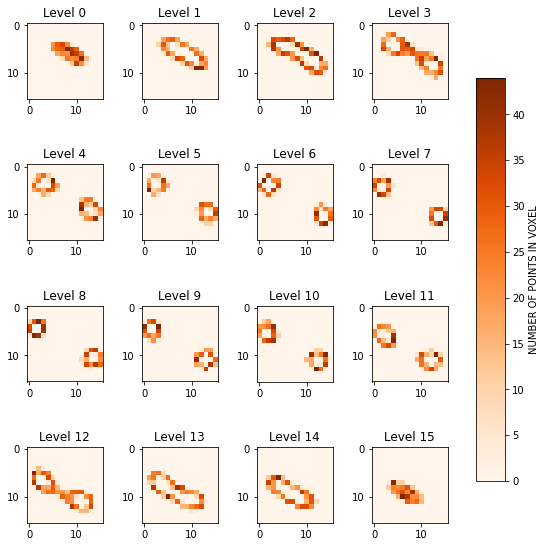

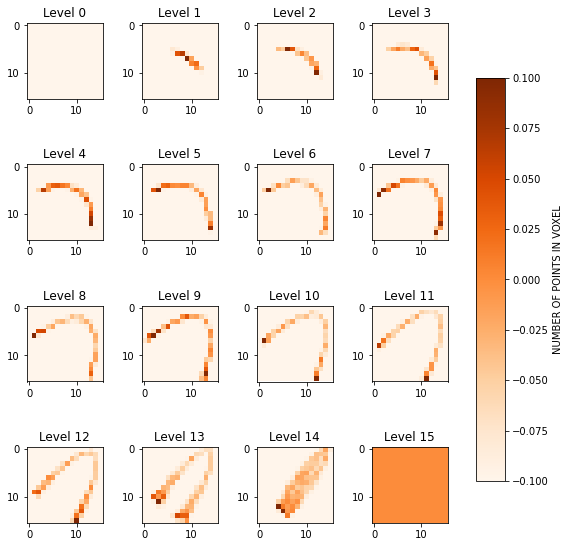

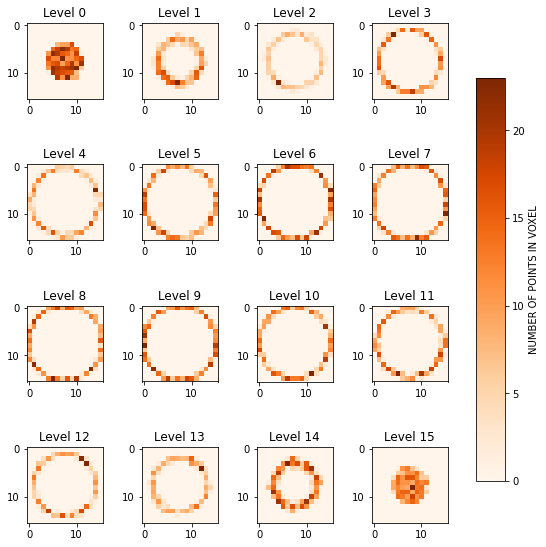

In [0]:
print(voxel_grid_torus.plot())
print(voxel_grid_cone.plot())
print(voxel_grid_sphere.plot())


In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=torus.points['x'],
    y=torus.points['y'],
    z=torus.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=cone.points['x'],
    y=cone.points['y'],
    z=cone.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
import plotly.graph_objects as go
import numpy as np

fig = go.Figure(data=[go.Scatter3d(
    x=sphere.points['x'],
    y=sphere.points['y'],
    z=sphere.points['z'],
    mode='markers',
    marker=dict(
        size=2,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
import numpy as np

def get_vox(name_, class_, range_):
  vox = []
  for i in range(range_):
    points = PyntCloud.from_file(f"dataset_figure/{name_}/{name_}_{i}.ply")
    cloud_points = points.get_sample("mesh_random", n=10000, as_PyntCloud=True)
    new_format_voxel = pd.DataFrame({"x": cloud_points.points['x'], "y": cloud_points.points['y'], "z":cloud_points.points['z']}).to_numpy() 
    voxel_grid = VoxelGrid(new_format_voxel, x_y_z=[16, 16, 16])
    #voxel_grid.build()
    _vector = np.reshape(voxel_grid.vector, (4096))
    _vector = np.hstack((_vector, class_))
    vox.append(_vector)
  return np.array(vox)

cone = get_vox('cone', 0, 1000)
sphere = get_vox('sphere', 1, 1000)
torus = get_vox('torus', 2, 1000)

print(cone.shape)
print(sphere.shape)
print(torus.shape)

dataset = np.concatenate((cone, sphere, torus))
print(dataset.shape)

  

(1000, 4097)
(1000, 4097)
(1000, 4097)
(3000, 4097)


In [0]:
np.random.shuffle(dataset)

In [0]:
import sys
np.set_printoptions(threshold=sys.maxsize)
x = dataset[:,:4096]
y = dataset[:,4096]
print(x.shape, y.shape)

(3000, 4096) (3000,)


In [0]:
train_x = x[:2000,]
train_y = y[:2000,]
print(train_x.shape, train_y.shape)
test_x = x[2000:,]
test_y = y[2000:,]
print(test_x.shape, test_y.shape)


(2000, 4096) (2000,)
(1000, 4096) (1000,)


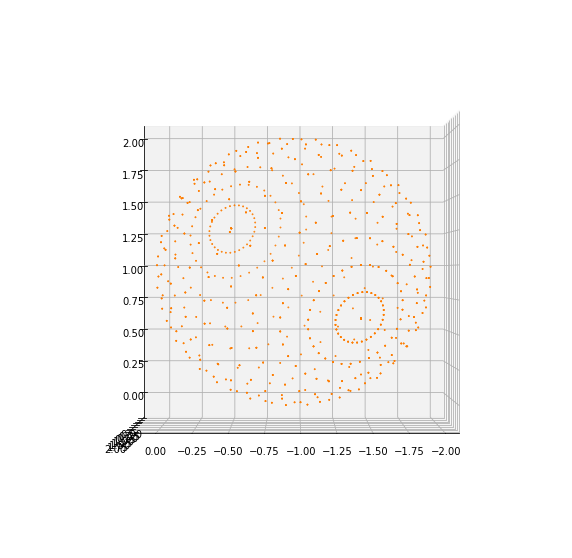

In [0]:
from pyntcloud import PyntCloud
import pandas as pd
cloud = PyntCloud.from_file("cube_0.ply")
cloud.plot()

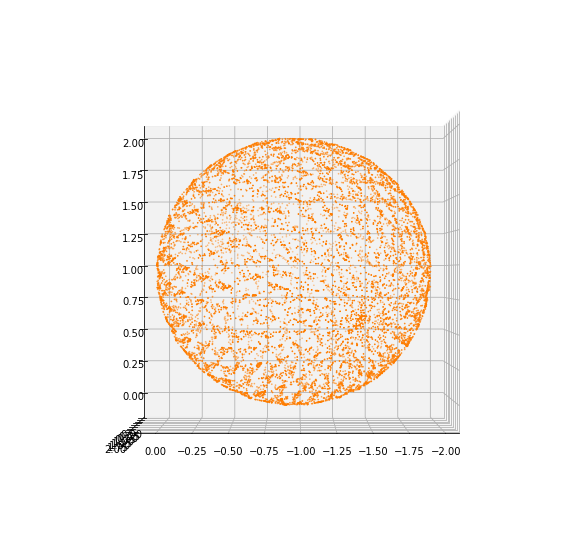

             x         y         z
0    -1.801082  0.831014  0.451864
1    -0.619001  0.934671  0.013374
2    -0.902695  1.783602  1.492217
3    -0.841499  1.476669  1.786178
4    -1.298344  1.546330  1.670773
...        ...       ...       ...
9995 -0.223253  0.771415  1.612627
9996 -0.981082 -0.042846  1.020615
9997 -0.224464  0.971450  1.638690
9998 -1.459339  1.361206  1.701970
9999 -1.793765  0.419667  0.859548

[10000 rows x 3 columns]
[[-1.8010819   0.83101434  0.45186427]
 [-0.61900145  0.9346713   0.01337385]
 [-0.9026952   1.7836015   1.4922173 ]
 ...
 [-0.22446406  0.97144955  1.6386898 ]
 [-1.4593395   1.3612058   1.7019702 ]
 [-1.7937651   0.41966748  0.8595479 ]]


In [0]:
dop_mesh = cloud.get_sample("mesh_random", n=10000, as_PyntCloud=True)
dop_mesh.plot()
print(dop_mesh.points)
new_data = pd.DataFrame({"x": dop_mesh.points['x'], "y": dop_mesh.points['y'], "z":dop_mesh.points['z']}).to_numpy() 
print(new_data)

In [0]:
voxel_grid = VoxelGrid(new_data, x_y_z=[16,16,16])

In [0]:
# point = cloud.get_mesh_vertices()

# dop_mesh = cloud.get_sample("mesh_random", n=10000, as_PyntCloud=True)
# # print(dop_mesh.points)
# x = dop_mesh.points['x'].values
# y = dop_mesh.points['y'].values
# z = dop_mesh.points['z'].values
# import numpy as np
# tmp = np.concatenate((x, y, z), axis=None)
# # print(tmp)

# # voxelgrid_id = dop_mesh.add_structure("voxelgrid", n_x=5, n_y=5, n_z=5)
# # voxelgrid = dop_mesh.structures[voxelgrid_id]
# # voxelgrid.get_feature_vector(mode="binary")
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# Axes3D.plot_trisurf(ax, x, y, z)

In [0]:
# !pip install open3d

In [0]:
# import numpy as np
# import open3d as o3d
# print("Testing IO for textured meshes ...")
# textured_mesh = o3d.io.read_triangle_mesh("untitled.obj")
# print(textured_mesh)
# o3d.io.write_triangle_mesh("untitled_.obj", textured_mesh, write_triangle_uvs=True)
# copy_textured_mesh = o3d.io.read_triangle_mesh('untitled_.obj')
# print(copy_textured_mesh)

Testing IO for textured meshes ...
geometry::TriangleMesh with 8 points and 12 triangles.
geometry::TriangleMesh with 8 points and 12 triangles.


In [0]:
# # !rm *
# !wget "https://ia802909.us.archive.org/19/items/3dMnist/3d-mnist.zip"
# !unzip 3d-mnist.zip

In [0]:
# !rm *
# from google.colab import files
# file = files.upload()
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle
# !kaggle competitions download -c digit-recognizer
# !kaggle datasets download -d daavoo/3d-mnist
# !ls
# !unzip 3d-mnist.zip

rm: cannot remove 'sample_data': Is a directory


Saving kaggle.json to kaggle.json
 82% 5.00M/6.09M [00:00<00:00, 11.7MB/s]
100% 6.09M/6.09M [00:00<00:00, 13.8MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 74.3MB/s]
 55% 5.00M/9.16M [00:00<00:00, 12.3MB/s]
100% 9.16M/9.16M [00:00<00:00, 20.7MB/s]
 90% 137M/153M [00:03<00:00, 34.8MB/s]
100% 153M/153M [00:03<00:00, 49.0MB/s]
3d-mnist.zip  sample_data  sample_submission.csv  test.csv.zip	train.csv.zip
Archive:  3d-mnist.zip
  inflating: full_dataset_vectors.h5  
  inflating: plot3D.py               
  inflating: test_point_clouds.h5    
  inflating: train_point_clouds.h5   
  inflating: voxelgrid.py            


(30, 30)


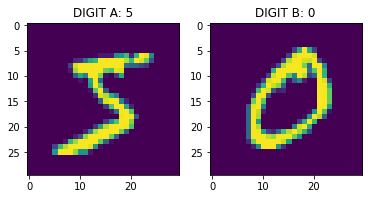

In [0]:
# import h5py
# import matplotlib.pyplot as plt

# with h5py.File("./train_point_clouds.h5", "r") as hf:    

#     a = hf["0"]
#     b = hf["1"]
    
#     digit_a = (a["img"][:], a["points"][:], a.attrs["label"]) 
#     digit_b = (b["img"][:], b["points"][:], b.attrs["label"])
#     print(a["img"][:].shape)


# plt.subplot(121)
# plt.title("DIGIT A: " + str(digit_a[2]))
# plt.imshow(digit_a[0])

# plt.subplot(122)
# plt.title("DIGIT B: " + str(digit_b[2]))
# plt.imshow(digit_b[0])


In [0]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
import plotly.graph_objs as go
from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
import h5py
import sys

init_notebook_mode(connected=True)
%matplotlib inline
# import tensorflow.compat.v1 as tf # https://stackoverflow.com/questions/56820327/the-name-tf-session-is-deprecated-please-use-tf-compat-v1-session-instead
# tf.disable_v2_behavior()

Using TensorFlow backend.


In [0]:
# with h5py.File('./full_dataset_vectors.h5', 'r') as dataset:
#     x_train = dataset["X_train"][:]
#     x_test = dataset["X_test"][:]
#     y_train = dataset["y_train"][:]
#     y_test = dataset["y_test"][:]

In [0]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# import numpy as np
# from matplotlib import pyplot as plt
# def plot(d=2, cmap="Oranges", axis=False):
#   if d == 2:
#       fig, axes= plt.subplots(int(np.ceil(self.n_z / 4)), 4, figsize=(8,8))
#       plt.tight_layout()
#       for i,ax in enumerate(axes.flat):
#           if i >= len(x_train[0]):
#               break
#           im = ax.imshow(x_train[0], cmap=cmap, interpolation="none")
#           ax.set_title("Level " + str(i))

#       fig.subplots_adjust(right=0.8)
#       cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#       cbar = fig.colorbar(im, cax=cbar_ax)
#       cbar.set_label('NUMBER OF POINTS IN VOXEL')
# plot()

In [0]:
# print ("x_train shape: ", x_train.shape)
# print ("y_train shape: ", y_train.shape)

# print ("x_test shape:  ", x_test.shape)
# print ("y_test shape:  ", y_test.shape)
# # np.set_printoptions(threshold=sys.maxsize)
# aaa = np.array(x_train[0]).reshape(64, 64)

# import matplotlib.pyplot as plt

# plt.subplot(121)
# plt.imshow(aaa[16::])

# # from mpl_toolkits.mplot3d import Axes3D
# # fig = plt.figure()
# # ax = fig.add_subplot(1111, projection='3d')

# # Axes3D.plot_surface(ax, train_npy[100], train_npy[100], train_npy[0], rstride=1, cstride=1,linewidth=1, antialiased=True)

In [0]:
# ## Introduce the channel dimention in the input dataset 
# xtrain = np.ndarray((x_train.shape[0], 4096, 3))
# xtest = np.ndarray((x_test.shape[0], 4096, 3))

# ## iterate in train and test, add the rgb dimention 
# def add_rgb_dimention(array):
#     scaler_map = cm.ScalarMappable(cmap="Oranges")
#     array = scaler_map.to_rgba(array)[:, : -1]
#     return array
# for i in range(x_train.shape[0]):
#     xtrain[i] = add_rgb_dimention(x_train[i])
# for i in range(x_test.shape[0]):
#     xtest[i] = add_rgb_dimention(x_test[i])

# ## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
# xtrain = xtrain.reshape(x_train.shape[0], 16, 16, 16, 3)
# xtest = xtest.reshape(x_test.shape[0], 16, 16, 16, 3)

# ## convert target variable into one-hot
# y_train = keras.utils.to_categorical(y_train, 10)
# y_test = keras.utils.to_categorical(y_test, 10)

In [0]:
## Introduce the channel dimention in the input dataset 
xtrain = np.ndarray((train_x.shape[0], 4096, 3))
xtest = np.ndarray((test_x.shape[0], 4096, 3))

## iterate in train and test, add the rgb dimention 
def add_rgb_dimention(array):
    scaler_map = cm.ScalarMappable(cmap="Oranges")
    array = scaler_map.to_rgba(array)[:, : -1]
    return array
for i in range(train_x.shape[0]):
    xtrain[i] = add_rgb_dimention(train_x[i])
for i in range(test_x.shape[0]):
    xtest[i] = add_rgb_dimention(test_x[i])

## convert to 1 + 4D space (1st argument represents number of rows in the dataset)
xtrain = xtrain.reshape(train_x.shape[0], 16, 16, 16, 3)
xtest = xtest.reshape(test_x.shape[0], 16, 16, 16, 3)

## convert target variable into one-hot
y_train = keras.utils.to_categorical(train_y, 3)
y_test = keras.utils.to_categorical(test_y, 3)

In [0]:
y_train.shape

(10000, 10)

In [0]:
# ## input layer
# input_layer = Input((16, 16, 16, 3))

# ## convolutional layers
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu')(conv_layer1)

# ## add max pooling to obtain the most imformatic features
# pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
# conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
# pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

# ## perform batch normalization on the convolution outputs before feeding it to MLP architecture
# pooling_layer2 = BatchNormalization()(pooling_layer2)
# flatten_layer = Flatten()(pooling_layer2)

# ## create an MLP architecture with dense layers : 4096 -> 512 -> 10
# ## add dropouts to avoid overfitting / perform regularization
# dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=10, activation='softmax')(dense_layer2)

# ## define the model with input layer and output layer
# model = Model(inputs=input_layer, outputs=output_layer)
# model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 14, 14, 14, 8)     656       
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 12, 12, 12, 16)    3472      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 6, 6, 6, 16)       0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 4, 4, 4, 32)       13856     
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 1, 1, 1, 64)       0   

In [0]:
## input layer
input_layer = Input((16, 16, 16, 3))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 3), activation='relu', padding='Same')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu', padding='Same')(conv_layer1)

## add max pooling to obtain the most imformatic features
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='Same')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='Same')(conv_layer3)

pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
dense_layer1 = Dense(units=4096, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.5)(dense_layer1)
dense_layer2 = Dense(units=1024, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.5)(dense_layer2)
output_layer = Dense(units=10, activation='softmax')(dense_layer2)

## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 16, 16, 3)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 16, 16, 8)     656       
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 16, 16, 16, 16)    3472      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 8, 8, 8, 16)       0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 8, 8, 8, 32)       13856     
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 8, 8, 8, 64)       55360     
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 4, 4, 4, 64)       0   

In [0]:
model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['acc'])
model.fit(x=xtrain, y=y_train, batch_size=64, epochs=10, validation_split=0)

Epoch 1/10
2000/2000 [==============================] - 9s 4ms/step - loss: 1.1327 - acc: 0.8500
Epoch 2/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.1623 - acc: 0.9620
Epoch 3/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0539 - acc: 0.9870
Epoch 4/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0048 - acc: 0.9990
Epoch 5/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0225 - acc: 0.9955
Epoch 6/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0018 - acc: 0.9995
Epoch 7/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0013 - acc: 0.9995
Epoch 8/10
2000/2000 [==============================] - 3s 1ms/step - loss: 2.7137e-05 - acc: 1.0000
Epoch 9/10
2000/2000 [==============================] - 3s 1ms/step - loss: 1.9397e-04 - acc: 1.0000
Epoch 10/10
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0029 - acc: 0.9995


In [0]:
# model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])
# model.fit(x=xtrain, y=y_train, batch_size=128, epochs=50, validation_split=0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 8s 953us/step - loss: 2.1433 - acc: 0.2410 - val_loss: 2.2663 - val_acc: 0.1820
Epoch 2/50
8000/8000 [==============================] - 1s 174us/step - loss: 1.6579 - acc: 0.4404 - val_loss: 2.1430 - val_acc: 0.3330
Epoch 3/50
8000/8000 [==============================] - 1s 170us/step - loss: 1.3550 - acc: 0.5408 - val_loss: 1.9620 - val_acc: 0.3195
Epoch 4/50
8000/8000 [==============================] - 1s 167us/step - loss: 1.1969 - acc: 0.5888 - val_loss: 1.7084 - val_acc: 0.5125
Epoch 5/50
8000/8000 [==============================] - 1s 169us/step - loss: 1.1009 - acc: 0.6225 - val_loss: 1.5823 - val_acc: 0.4810
Epoch 6/50
8000/8000 [==============================] - 1s 171us/step - loss: 1.0317 - acc: 0.6423 - val_loss: 1.3481 - val_acc: 0.5575
Epoch 7/50
8000/8000 [==============================] - 1s 168us/step - loss: 0.9772 - acc: 0.6635 - val_loss: 1.2100 - val_acc: 0.5990


In [0]:
pred = model.predict(xtest)
pred = np.argmax(pred, axis=1)
pred = keras.utils.to_categorical(pred, num_classes=10)

accuracy = np.sum(pred * y_test) / len(y_test)
accuracy*100

64.55